In [1]:
from utilities import *

In [2]:
dataset_run = database_covers('map_data/temp/')
points_run = parse_gpx_to_points('gpx_data/104_MINUS_2.gpx')
(result_run, elevation_map_run) = get_elevation_for_points(dataset_run, points_run)

In [207]:
len(elevation_map_run)

4067

In [ ]:
import matplotlib.pyplot as plt

In [271]:
def cut_to_threshold(data, threshold):
    x = [0]
    y_res = [data[0]]
    temp = 0
    for i in range(1, len(data)):
        temp += data[i] - data[i - 1]
        if temp > threshold or temp < -threshold:
            x.append(i)
            y_res.append(data[i])
            temp = 0

    x.append(len(data) - 1)
    y_res.append(data[-1])

    return x, y_res


In [391]:
import numpy as np

ELE_THRESHOLD = 0.05

def test(SUMOF, THRESHOLD):
    # x_res, y_res = cut_to_threshold(elevation_map_run, THRESHOLD)
    x_res, y_res = cut_to_threshold(elevation_map_run, THRESHOLD)
    y_diff = [0 for i in range(len(elevation_map_run))]

    for i in range(1, len(y_res)):
        y_diff[x_res[i]] = y_res[i] - y_res[i - 1]

    y_diff = np.array(y_diff)
    y_up = np.cumsum((y_diff >= 0) * y_diff)
    y_down = np.cumsum((y_diff <= 0) * y_diff)

    def find_climbs_descends(diffs):
        climbs, descends = [], []
        last_ele = diffs[0]
        temp = 0
        for i in range(1, len(diffs)):
            if last_ele * diffs[i] < 0:
                if y_up[i - 1] - y_up[temp] - (y_down[i - 1] - y_down[temp]) < ELE_THRESHOLD:
                    continue
                if last_ele > 0:
                    climbs.append((temp, i - 1))
                elif last_ele < 0:
                    descends.append((temp, i - 1))
                last_ele = diffs[i]
                temp = i

        if last_ele < 0:
            descends.append((temp, len(diffs) - 1))
        else:
            climbs.append((temp, len(diffs) - 1))
        return climbs, descends

    np_y = np.array(y_res)
    diff = np_y[1:] - np_y[:-1]

    sum25 = [sum(diff[i:i+SUMOF]) for i in range(len(diff) - SUMOF)]
    sum25 = np.array(sum25)

    climbs, descends = find_climbs_descends(sum25)

    # data_cutx = np.array(x_res)
    # data_cuty = np.array(y_res)

    # begin_climb = [data_cutx[i] for i in climbs]
    # begin_descend = [data_cutx[i] for i in descends]
    # # Descending is first
    # # print([x_res[x] for x in climbs])
    # if 0 in descends:
    #     end_descend = [begin_climb[i] - 1 for i in range(len(begin_climb))]
    #     end_climb = [begin_descend[i] - 1 for i in range(len(begin_descend))][1:]
    # else:
    #     end_climb = [begin_descend[i] - 1 for i in range(len(begin_descend))]
    #     end_descend = [begin_climb[i] - 1 for i in range(len(begin_climb))][1:]

    # if end_descend[-1] > end_climb[-1]:
    #     end_climb += [len(elevation_map_run) - 1]   
    # else:
    #     end_descend += [len(elevation_map_run) - 1]

    # print(len(begin_climb), len(end_climb), len(begin_descend), len(end_descend))
    ascends = [1 for i in range(len(elevation_map_run))]
    for i in range(len(descends)):
        for j in range(descends[i][0], descends[i][1]):
            # print(j)
            ascends[j] = -1
    return ascends

In [392]:
results = []
for threshold in np.arange(0.1, 1.0, 0.1):
    for sumof in range(5, 25, 2):
        try:
            res = test(sumof, threshold)
            results.append(res)
        except:
            continue
        

import numpy as np
res_np = np.array(results)

# plt.figure(figsize=(16, 8))
# plt.imshow(res_np, cmap='Greens')
# # plt.colorbar()
# plt.show()

sumarr = np.sum(res_np, axis=0)

ELE_THRESHOLD = 0.5

def find_climbs_descends(diffs):
    climbs, descends = [], []
    last_ele = diffs[0]
    temp = 0
    for i in range(1, len(diffs)):
        if last_ele * diffs[i] < 0:
            if last_ele > 0:
                climbs.append((temp, i - 1))
            elif last_ele < 0:
                descends.append((temp, i - 1))
            last_ele = diffs[i]
            temp = i

    if last_ele < 0:
        descends.append((temp, len(diffs) - 1))
    else:
        climbs.append((temp, len(diffs) - 1))
    return climbs, descends

climbs, descends = find_climbs_descends(sumarr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


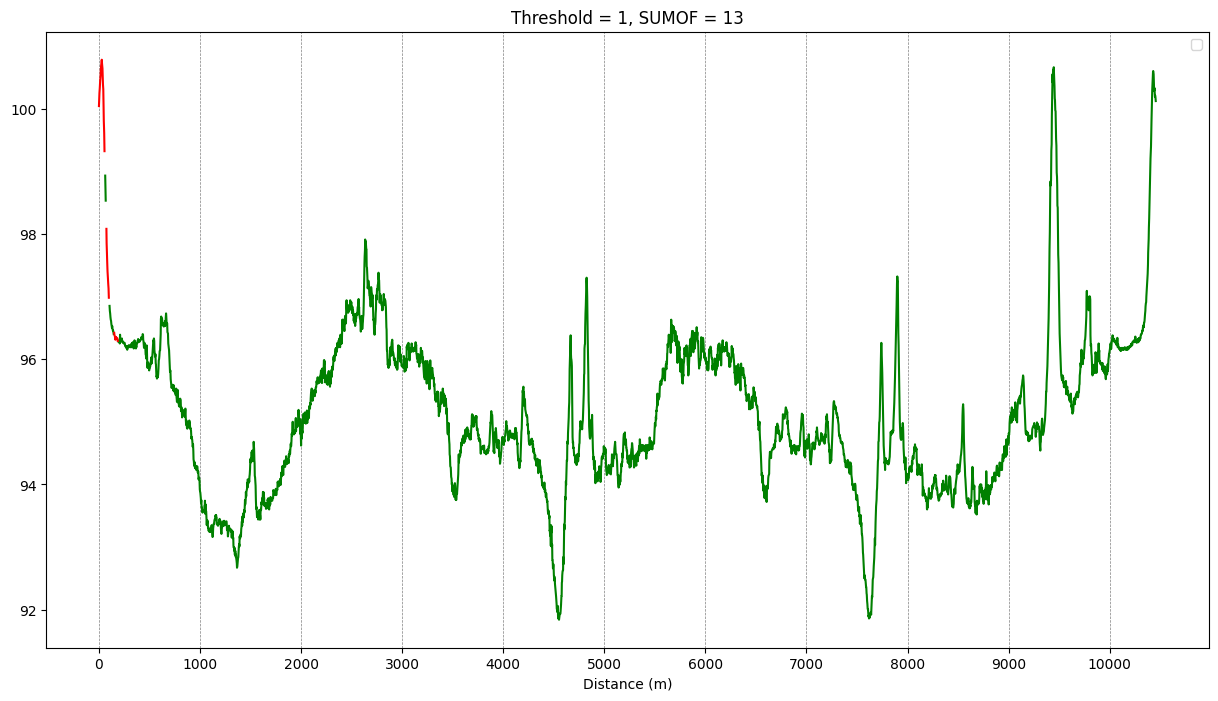

In [393]:
def distance(point1, point2):
    from haversine import haversine
    point1 = (point1[1], point1[0])
    point2 = (point2[1], point2[0])
    return haversine(point1, point2)

def points_to_cumulativedistance(points):
    cumulativedistance = [0]
    for i in range(1, len(points)):
        cumulativedistance.append(cumulativedistance[-1] + distance(points[i - 1][0], points[i][0]))
    return cumulativedistance

cumsum = [int(x * 1000) for x in points_to_cumulativedistance(points_run)]

plt.figure(figsize=(15, 8))
plt.xlabel('Distance (m)')
plt.xticks(range(0, cumsum[-1], 1000))
for i in range(0, cumsum[-1], 1000):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# x_res_sum = [cumsum[x] for x in x_res]
for begin_climb, end_climb in climbs:
    plt.plot([cumsum[x] for x in range(begin_climb, end_climb)], elevation_map_run[begin_climb:end_climb], color='green')
    # plt.plot([cumsum[x] for x in [begin_climb[i], end_climb[i]]],  [elevation_map_run[begin_climb[i]], elevation_map_run[end_climb[i]]] , color='green')
    

for begin_descend, end_descend in descends:
    # plt.plot([cumsum[x] for x in [begin_descend[i], end_descend[i]]],  [elevation_map_run[begin_descend[i]], elevation_map_run[end_descend[i]]] , color='red')
    plt.plot([cumsum[x] for x in range(begin_descend, end_descend)], elevation_map_run[begin_descend:end_descend], color='red')

plt.title('Threshold = {THRESHOLD}, SUMOF = {SUMOF}'.format(THRESHOLD=1, SUMOF=SUMOF))
plt.legend()
plt.show()

In [354]:
x_, y_ = cut_to_threshold(elevation_map_run, 0.25)
y__ = [0 for i in range(len(elevation_map_run))]

for i in range(1, len(y_)):
    y__[x_[i]] = y_[i] - y_[i - 1]

y__ = np.array(y__)
y_up = np.cumsum((y__ >= 0) * y__)
y_down = np.cumsum((y__ <= 0) * y__)

In [332]:
len(y_up)

4067

In [367]:
def uwu(data, asc, desc, threshold):
    x_, y_ = cut_to_threshold(data, threshold)
    y = [0 for i in range(len(data))]
    
    # print(x_)
    # print(y_)
    # print(len(x_), len(y_))
    for i in range(1, len(y_)):
        y[x_[i]] = y_[i] - y_[i - 1]
    
    y = np.array(y)
    y_up = np.cumsum((y >= 0) * y)
    y_down = np.cumsum((y <= 0) * y)

    # print("Ascends:")
    llist = []
    for (a, b) in asc:
        # print("{}-{}: {:.2f}+ {:.2f}-".format(cumsum[a], cumsum[b], y_up[b] - y_up[a], y_down[b] - y_down[a]))
        llist.append((cumsum[a], cumsum[b], y_up[b] - y_up[a], y_down[b] - y_down[a], y_up[b] - y_up[a] + y_down[b] - y_down[a]))

    # print("Descends:")
    for (a, b) in desc:
        # print("{}-{}: {:.2f}+ {:.2f}-".format(cumsum[a], cumsum[b], y_up[b] - y_up[a], y_down[b] - y_down[a]))
        llist.append((cumsum[a], cumsum[b], y_up[b] - y_up[a], y_down[b] - y_down[a], y_up[b] - y_up[a] + y_down[b] - y_down[a]))

    import prettytable
    tb = prettytable.PrettyTable()
    tb.field_names = ["Begin", "End", "Up", "Down"]
    llist.sort()
    for (a, b, c, d, e) in llist:
        tb.add_row([a, b, round(c, 2), round(-d, 2)])
    
    print(tb)

uwu(elevation_map_run, climbs, descends, 0.2)


+-------+-------+-------+-------+
| Begin |  End  |   Up  |  Down |
+-------+-------+-------+-------+
|   0   |  1462 |  3.12 |  9.28 |
|  1465 |  2685 |  7.5  |  4.25 |
|  2688 |  4569 |  7.9  | 12.88 |
|  4572 |  4828 |  7.21 |  1.99 |
|  4831 |  5245 |  1.92 |  4.56 |
|  5247 |  5292 |  0.21 |  0.22 |
|  5294 |  5499 |  0.41 |  -0.0 |
|  5501 |  5667 |  1.79 |  0.5  |
|  5669 |  7640 |  7.6  | 12.25 |
|  7642 |  7904 |  7.36 |  2.03 |
|  7906 |  8348 |  1.15 |  4.21 |
|  8351 |  8394 |  0.23 |  -0.0 |
|  8397 |  8530 |  0.94 |  0.68 |
|  8533 |  8561 |  0.57 |  0.38 |
|  8564 |  8583 |  0.0  |  0.46 |
|  8586 |  9468 | 10.08 |  4.31 |
|  9470 |  9754 |  1.12 |  4.68 |
|  9757 | 10459 |  6.27 |  2.12 |
+-------+-------+-------+-------+
